# Playground for strokes graph

In [21]:
# import libraries
import geopandas as gpd
import matplotlib.pyplot as plt
import momepy
import networkx as nx
import folium
from itertools import combinations
from shapely import LineString
import numpy as np
import math
import pickle
from collections import Counter

In [22]:
# https://carto.com/carto-colors/ > Prism
colors_list = [
    "#5F4690",
    "#1D6996",
    "#38A6A5",
    "#0F8554",
    "#73AF48",
    "#EDAD08",
    "#E17C05",
    "#CC503E",
    "#94346E",
    "#6F4070",
    "#994E95",
    "#666666"
]

Import example data set

In [23]:
# read in toy graph (Bubenec)
streets = gpd.read_file(momepy.datasets.get_path("bubenec"), layer="streets")

Workflow (will be wrapped in function later)

- [ ] input is a set of linestrings
- [ ] remove false nodes 
- [ ] convert linestrings to primal graph
- [ ] get points and lines gdf from primal graph
- [ ] run COINS on lines gdf to find strokes
- [ ] add mapping of strokeID:edgeIDs to stroke gdf (use momepy's **edge ID**, not indexing)
- [ ] add stroke attribute to each edge on primal graph

In [24]:
# define variable defaults (will be arguments passed to future function)
angle_threshold=0
flow_mode=False

In [25]:
# remove false nodes
streets = momepy.remove_false_nodes(streets)

# add unique edge ID to streets, already HERE!
# streets["edge_id"] = streets.index

# make primal graph
graph = momepy.gdf_to_nx(
    streets, 
    preserve_index=True, # index of lines gdf should be referring to EXACTLY THE SAME ELEMENT as index of streets gdf
    approach="primal"
)

# get gdfs of points and lines
points, lines = momepy.nx_to_gdf(graph, points=True, lines=True)

# # asserting that our edge indeces didn't get messed up
# assert(len(lines) == len(streets))

# for i, row in lines.iterrows():
#     assert(row["geometry"] == streets.loc[i,"geometry"])

lines["my_index"] = lines.index # just for plotting TODO remove later

# each row is an edge
lines.head()


,geometry,mm_len,node_start,node_end,my_index
0,"LINESTRING (1603585.64 6464428.774, 1603413.20...",264.103950,0,1,0
1,"LINESTRING (1603268.502 6464060.781, 1603296.8...",99.751190,2,3,1
2,"LINESTRING (1603607.303 6464181.853, 1603592.8...",199.746503,1,4,2
3,"LINESTRING (1603363.558 6464031.885, 1603376.5...",203.014090,1,3,3
4,"LINESTRING (1603413.206 6464228.73, 1603274.45...",198.482724,1,5,4


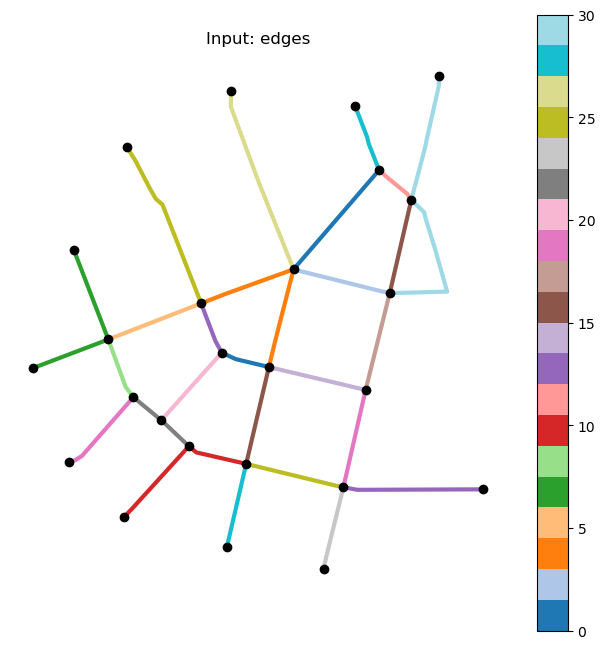

In [26]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
lines.plot(ax=ax, column="my_index", cmap="tab20", lw=3, legend=True, zorder=0)
points.plot(ax=ax, color = "black", zorder=1)
ax.set_axis_off()
plt.title("Input: edges")
plt.show()

In [27]:
# make coins
coins = momepy.COINS(lines, angle_threshold=angle_threshold, flow_mode=flow_mode)

# get gdfs from COINS class
stroke_attribute = coins.stroke_attribute()
stroke_gdf = coins.stroke_gdf()
stroke_gdf["rep_point"] = stroke_gdf.geometry.apply(lambda x: x.interpolate(0.5, normalized=True))

# add stroke_id column
stroke_gdf["stroke_id"] = stroke_gdf.index

stroke_gdf.head()

,n_segments,geometry,rep_point,stroke_id
stroke_group,,,,
0,8,"LINESTRING (1603278.899 6463669.186, 1603283.7...",POINT (1603374.663 6464077.898),0
1,19,"LINESTRING (1603077.5 6464475.323, 1603085.515...",POINT (1603237.049 6464133.622),1
2,17,"LINESTRING (1603537.194 6464558.112, 1603557.6...",POINT (1603707.107 6464238.854),2
3,5,"LINESTRING (1603413.206 6464228.73, 1603274.45...",POINT (1603149.929 6464130.225),3
4,14,"LINESTRING (1602970.377 6464268.058, 1602974.0...",POINT (1603264.658 6463848.976),4


In [28]:
# add edge_ids column (using COINS.stroke_attribute to map into ID defined in lines gdf)
stroke_gdf["edge_indeces"] = stroke_gdf.stroke_id.apply(
    lambda x: list(stroke_attribute[stroke_attribute==x].index)
)

stroke_gdf.head()

,n_segments,geometry,rep_point,stroke_id,edge_indeces
stroke_group,,,,,
0,8,"LINESTRING (1603278.899 6463669.186, 1603283.7...",POINT (1603374.663 6464077.898),0,"[0, 3, 15, 27]"
1,19,"LINESTRING (1603077.5 6464475.323, 1603085.515...",POINT (1603237.049 6464133.622),1,"[1, 12, 14, 25]"
2,17,"LINESTRING (1603537.194 6464558.112, 1603557.6...",POINT (1603707.107 6464238.854),2,"[2, 11, 28, 30]"
3,5,"LINESTRING (1603413.206 6464228.73, 1603274.45...",POINT (1603149.929 6464130.225),3,"[4, 5, 6]"
4,14,"LINESTRING (1602970.377 6464268.058, 1602974.0...",POINT (1603264.658 6463848.976),4,"[7, 8, 9, 13, 21, 22, 24]"


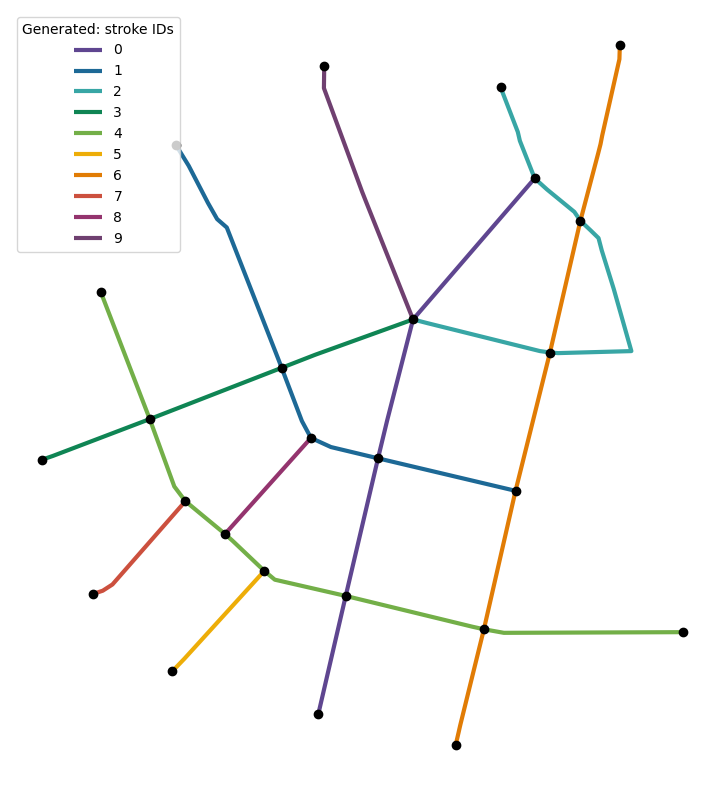

In [29]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
for stroke_id in stroke_gdf.stroke_id:
    stroke_gdf[stroke_gdf.stroke_id==stroke_id].plot(ax=ax, lw=3, label=stroke_id, zorder=0, color=colors_list[stroke_id])
points.plot(ax=ax, color = "black", zorder=1)
ax.set_axis_off()
ax.legend(title="Generated: stroke IDs")
plt.show()

In [30]:
# make dictionary for primal graph: d={edge_index:edge_name}
# where edge_name (in momepy language) is the corresponding node tuple
d_name2index = nx.get_edge_attributes(graph, "index_position")
d_index2name = {v:k for k,v in d_name2index.items()}

# for each edge, add "stroke_id" as attribute to graph
for _, row in stroke_gdf.iterrows():
    for edge_index in row.edge_indeces: 
        graph.edges[d_index2name[edge_index]]["stroke_id"] = row.stroke_id

# getting dicts of edge name : stroke ID, and edge index : stroke id # TODO: one of them might be obsolete?
d_name2stroke = nx.get_edge_attributes(graph, "stroke_id")
d_index2stroke = {d_name2index[k]:v for k,v in d_name2stroke.items()} 

In [31]:
lines.head()

,geometry,mm_len,node_start,node_end,my_index
0,"LINESTRING (1603585.64 6464428.774, 1603413.20...",264.103950,0,1,0
1,"LINESTRING (1603268.502 6464060.781, 1603296.8...",99.751190,2,3,1
2,"LINESTRING (1603607.303 6464181.853, 1603592.8...",199.746503,1,4,2
3,"LINESTRING (1603363.558 6464031.885, 1603376.5...",203.014090,1,3,3
4,"LINESTRING (1603413.206 6464228.73, 1603274.45...",198.482724,1,5,4


In [32]:
m = stroke_gdf.explore(tiles="cartodb.positron", column = "stroke_id", name = "strokes", cmap = "Reds", style_kwds={"weight":8})
lines.explore(m=m, column = "my_index", name = "lines", cmap = "Blues", style_kwds={"weight":8})
folium.LayerControl().add_to(m)
m

* Now we have a primal graph `graph` where each edge has the attributes `edge_id` and `stroke_id`
* We have this information also in `stroke_gdf`
* Each stroke (each line in stroke_gdf) will be a node of the stroke graph

In [33]:
def get_interior_angle(a, b, c):
    """
    Measure the angle between a-b, b-c (in degrees).
    """
    ba = [a[0]-b[0],a[1]-b[1]]
    bc = [c[0]-b[0],c[1]-b[1]]
    # np.dot(ba, bc) # ba[0]*bc[0] + ba[1]*bc[1]
    # np.linalg.norm(ba) # np.sqrt(ba[0]**2+ba[1]**2)
    # np.linalg.norm(bc) # np.sqrt(bc[0]**2+bc[1]**2)
    theta_rad = math.acos(np.dot(ba,bc)/(np.linalg.norm(ba)*np.linalg.norm(bc)))
    theta_deg = np.degrees(theta_rad)
    if theta_deg > 90:
        theta_deg = 180 - theta_deg
    return theta_deg

def get_segment(geom, n):
    '''
    geom... linestring.
    n.... coordinate of start-or-end node on linestring.
    returns: coordinate tuple (n, adjacent-to-n), in THAT ORDER
        (ie. if n is start node, returns coords in position 0 and 1;
        if n is end node, reutnrs coords in position n, n-1
        )
    '''
    coords = [c for c in geom.coords]
    index_n = coords.index(n)
    if index_n == 0:
        return coords[0:2]
    elif index_n == len(coords)-1:
        return [coords[index_n], coords[index_n-1]]
    else:
        raise ValueError("Node not on end of edge?")

# use angles_gdf length to add to connectivity of strokes (nodes)
def get_connectivity(angles_gdf):
    if len(angles_gdf)==4:
        return 2
    elif len(angles_gdf) in [2,3]:
        return 1
    else:
        raise ValueError("Unexpected number of edge segments in angles_gdf")


In [34]:
stroke_graph = nx.Graph()
stroke_graph.graph["crs"] = graph.graph["crs"]
stroke_graph.graph["approach"] = graph.graph["approach"]
stroke_graph.add_nodes_from(
    [
        (
            row.stroke_id, 
            {
                "edge_indeces": row.edge_indeces,
                "geometry": row.rep_point,
                "geometry_stroke": row.geometry,
                "x": row.rep_point.xy[0][0],
                "y": row.rep_point.xy[1][0],
                "connectivity": 0
            }
        ) for _, row in stroke_gdf.iterrows()
    ]
)
# node names are the stroke IDs.
# each node has the attribute "edge_indeces".
stroke_graph.nodes(data=True)

NodeDataView({0: {'edge_indeces': [0, 3, 15, 27], 'geometry': <POINT (1603374.663 6464077.898)>, 'geometry_stroke': <LINESTRING (1603278.899 6463669.186, 1603283.731 6463690.028, 1603314.444 6...>, 'x': 1603374.6625343116, 'y': 6464077.898491419, 'connectivity': 0}, 1: {'edge_indeces': [1, 12, 14, 25], 'geometry': <POINT (1603237.049 6464133.622)>, 'geometry_stroke': <LINESTRING (1603077.5 6464475.323, 1603085.515 6464462.306, 1603095.2 64644...>, 'x': 1603237.0487682838, 'y': 6464133.622486805, 'connectivity': 0}, 2: {'edge_indeces': [2, 11, 28, 30], 'geometry': <POINT (1603707.107 6464238.854)>, 'geometry_stroke': <LINESTRING (1603537.194 6464558.112, 1603557.688 6464504.985, 1603561.74 64...>, 'x': 1603707.1065106073, 'y': 6464238.853991265, 'connectivity': 0}, 3: {'edge_indeces': [4, 5, 6], 'geometry': <POINT (1603149.929 6464130.225)>, 'geometry_stroke': <LINESTRING (1603413.206 6464228.73, 1603274.458 6464178.659, 1603226.958 64...>, 'x': 1603149.9288811635, 'y': 6464130.22450323

to find the **edges** of the stroke graph, we look at the primal `graph`'s nodes and the stroke_ids of their adjacent edges

Node: 0
Adjacent strokes (list): [0, 2, 2]
Adjacent strokes (uniques): {0, 2}
Checking edge: (0, 2)


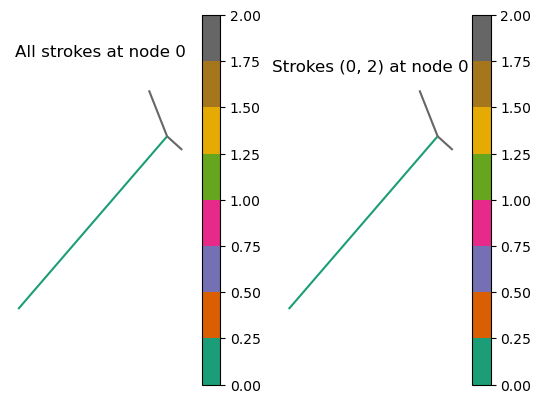

angles_gdf len 3
connectivity: 1
Counter values: dict_values([1, 2])
angles: [np.float64(62.302182356951434)]
(0, 2) added
**************************************************************
 
 

Node: 1
Adjacent strokes (list): [0, 2, 0, 3, 9]
Adjacent strokes (uniques): {0, 9, 2, 3}
Checking edge: (0, 9)


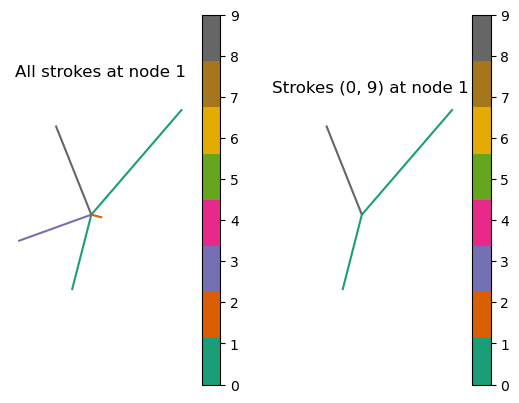

angles_gdf len 3
connectivity: 1
Counter values: dict_values([2, 1])
angles: [np.float64(36.134980718680936)]
(0, 9) added
Checking edge: (0, 2)


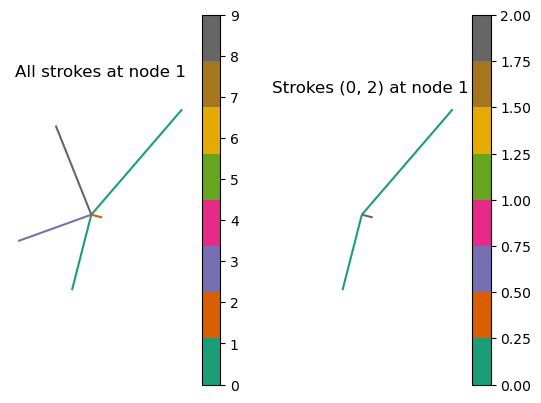

angles_gdf len 3
connectivity: 1
Counter values: dict_values([2, 1])
angles: [np.float64(63.647466378271766)]
(0, 2) already in graph, angles = [np.float64(62.302182356951434)]
(0, 2) already in graph, angles updated = [np.float64(62.302182356951434), np.float64(63.647466378271766)]
Checking edge: (0, 3)


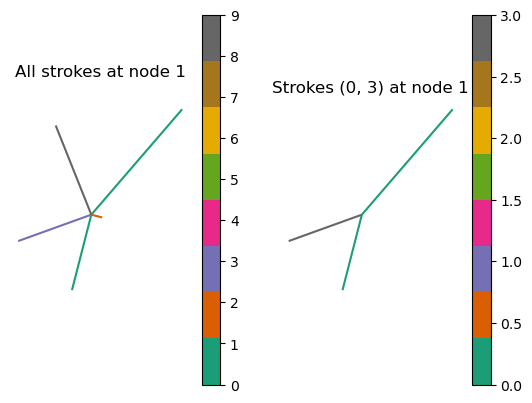

angles_gdf len 3
connectivity: 1
Counter values: dict_values([2, 1])
angles: [np.float64(29.396028363390087)]
(0, 3) added
Checking edge: (9, 2)


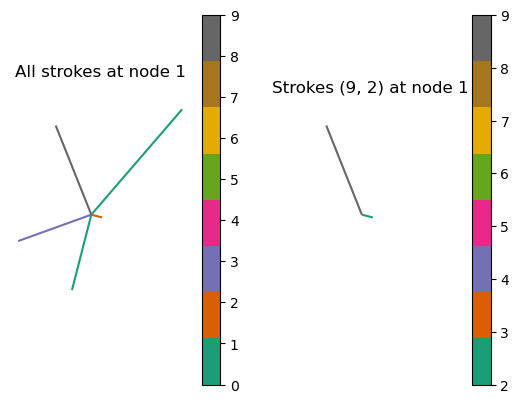

angles_gdf len 2
connectivity: 1
Counter values: dict_values([1, 1])
angles: [np.float64(53.8322224050728)]
(9, 2) added
Checking edge: (9, 3)


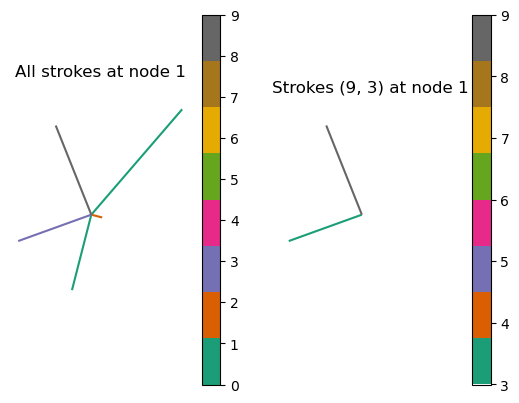

angles_gdf len 2
connectivity: 1
Counter values: dict_values([1, 1])
angles: [np.float64(88.08366041995446)]
(9, 3) added
Checking edge: (2, 3)


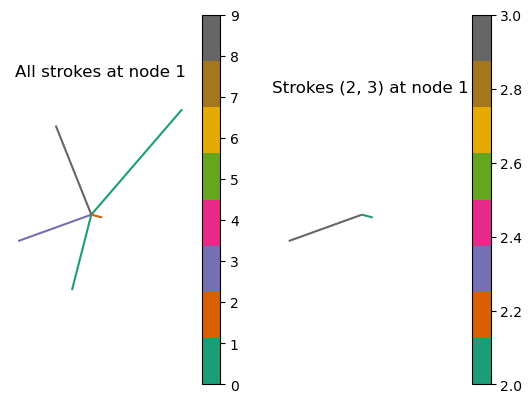

angles_gdf len 2
connectivity: 1
Counter values: dict_values([1, 1])
angles: [np.float64(34.25143801488164)]
(2, 3) added
**************************************************************
 
 

Node: 2
Adjacent strokes (list): [1, 1, 8]
Adjacent strokes (uniques): {8, 1}
Checking edge: (8, 1)


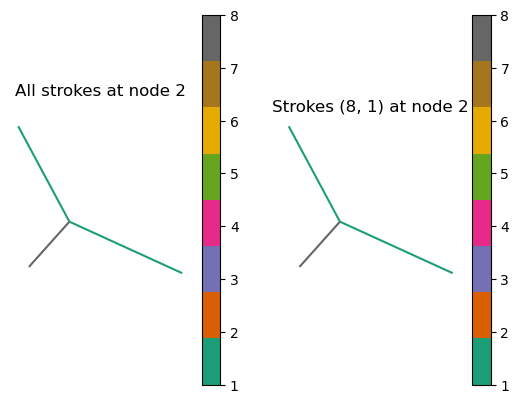

angles_gdf len 3
connectivity: 1
Counter values: dict_values([2, 1])
angles: [np.float64(70.04113695824684)]
(8, 1) added
**************************************************************
 
 

Node: 3
Adjacent strokes (list): [1, 0, 1, 0]
Adjacent strokes (uniques): {0, 1}
Checking edge: (0, 1)


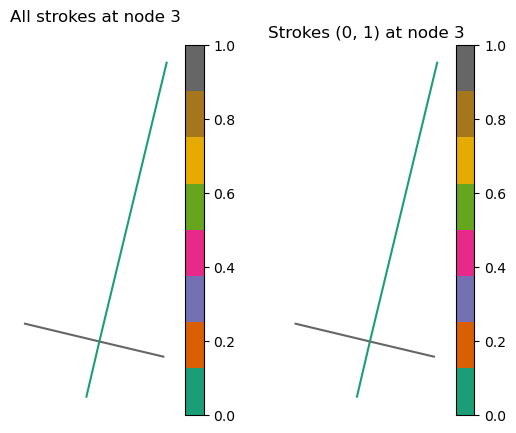

angles_gdf len 4
Interior angles found: [np.float64(89.87471285219927), np.float64(89.74560192447649)]
Interior angles found: [np.float64(89.75267804978043), np.float64(89.88178897750322)]
Final angles found: [np.float64(89.74560192447649), np.float64(89.75267804978043)]
connectivity: 2
Counter values: dict_values([2, 2])
angles: [np.float64(89.74560192447649), np.float64(89.75267804978043)]
(0, 1) added
**************************************************************
 
 

Node: 4
Adjacent strokes (list): [2, 6, 2, 6]
Adjacent strokes (uniques): {2, 6}
Checking edge: (2, 6)


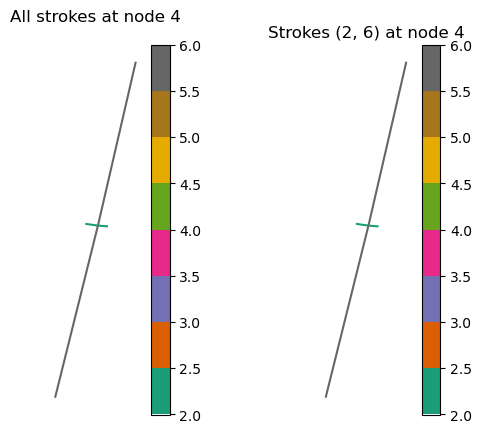

angles_gdf len 4
Interior angles found: [np.float64(85.21096368451747), np.float64(84.23886881283048)]
Interior angles found: [np.float64(81.14186114900058), np.float64(80.16976627731358)]
Final angles found: [np.float64(84.23886881283048), np.float64(80.16976627731358)]
connectivity: 2
Counter values: dict_values([2, 2])
angles: [np.float64(84.23886881283048), np.float64(80.16976627731358)]
(2, 6) added
**************************************************************
 
 

Node: 5
Adjacent strokes (list): [3, 3, 1, 1]
Adjacent strokes (uniques): {1, 3}
Checking edge: (1, 3)


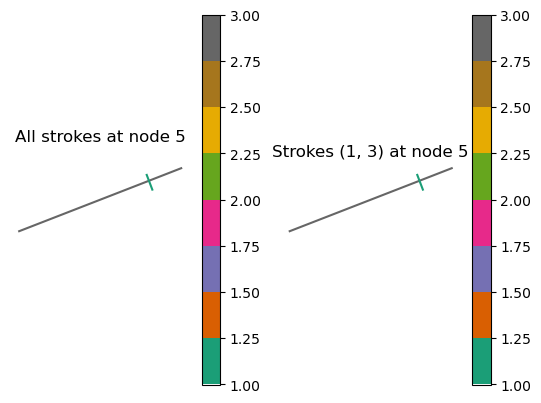

angles_gdf len 4
Interior angles found: [np.float64(89.53084497276808), np.float64(89.57504791798526)]
Interior angles found: [np.float64(89.58581817377714), np.float64(89.63002111899432)]
Final angles found: [np.float64(89.53084497276808), np.float64(89.58581817377714)]
connectivity: 2
Counter values: dict_values([2, 2])
angles: [np.float64(89.53084497276808), np.float64(89.58581817377714)]
(1, 3) added
**************************************************************
 
 

Node: 6
Adjacent strokes (list): [3, 3, 4, 4]
Adjacent strokes (uniques): {3, 4}
Checking edge: (3, 4)


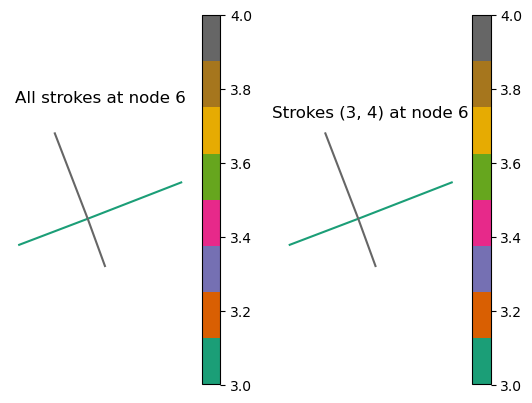

angles_gdf len 4
Interior angles found: [np.float64(89.83847705650136), np.float64(88.78833801117518)]
Interior angles found: [np.float64(89.75197989966416), np.float64(89.19788105500966)]
Final angles found: [np.float64(88.78833801117518), np.float64(89.19788105500966)]
connectivity: 2
Counter values: dict_values([2, 2])
angles: [np.float64(88.78833801117518), np.float64(89.19788105500966)]
(3, 4) added
**************************************************************
 
 

Node: 7
Adjacent strokes (list): [3]
Adjacent strokes (uniques): {3}
**************************************************************
 
 

Node: 8
Adjacent strokes (list): [4]
Adjacent strokes (uniques): {4}
**************************************************************
 
 

Node: 9
Adjacent strokes (list): [4, 7, 4]
Adjacent strokes (uniques): {4, 7}
Checking edge: (4, 7)


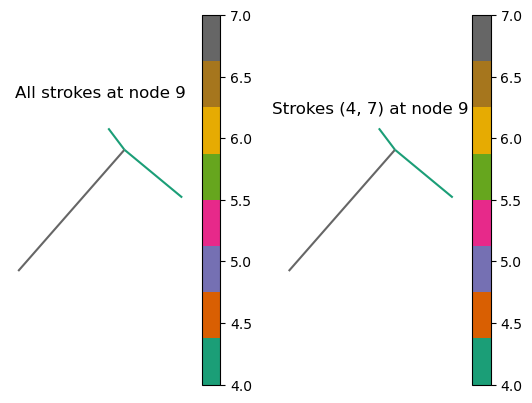

angles_gdf len 3
connectivity: 1
Counter values: dict_values([2, 1])
angles: [np.float64(78.26155769686821)]
(4, 7) added
**************************************************************
 
 

Node: 10
Adjacent strokes (list): [4, 0, 4, 0]
Adjacent strokes (uniques): {0, 4}
Checking edge: (0, 4)


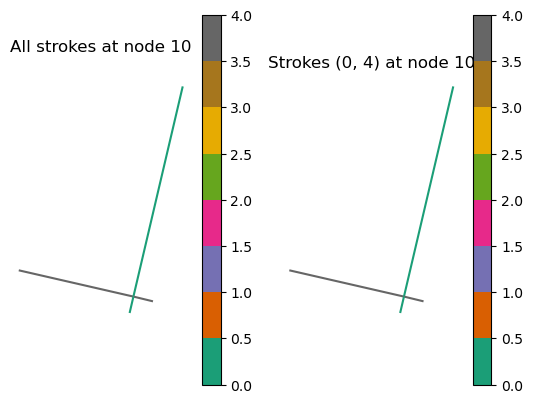

angles_gdf len 4
Interior angles found: [np.float64(89.70671191496507), np.float64(89.56623033507175)]
Interior angles found: [np.float64(89.84379058832397), np.float64(89.42915166171285)]
Final angles found: [np.float64(89.56623033507175), np.float64(89.42915166171285)]
connectivity: 2
Counter values: dict_values([2, 2])
angles: [np.float64(89.56623033507175), np.float64(89.42915166171285)]
(0, 4) added
**************************************************************
 
 

Node: 11
Adjacent strokes (list): [4, 5, 4]
Adjacent strokes (uniques): {4, 5}
Checking edge: (4, 5)


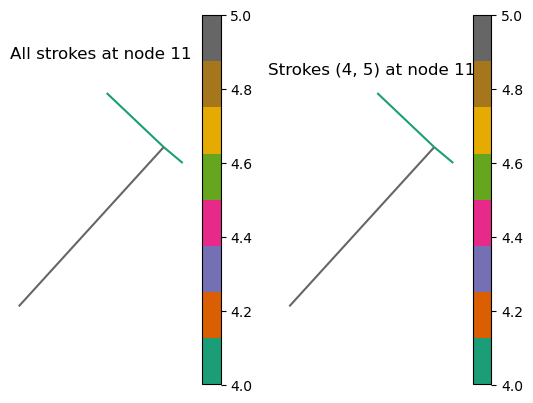

angles_gdf len 3
connectivity: 1
Counter values: dict_values([2, 1])
angles: [np.float64(87.60977577529626)]
(4, 5) added
**************************************************************
 
 

Node: 12
Adjacent strokes (list): [5]
Adjacent strokes (uniques): {5}
**************************************************************
 
 

Node: 13
Adjacent strokes (list): [2, 6, 2, 6]
Adjacent strokes (uniques): {2, 6}
Checking edge: (2, 6)


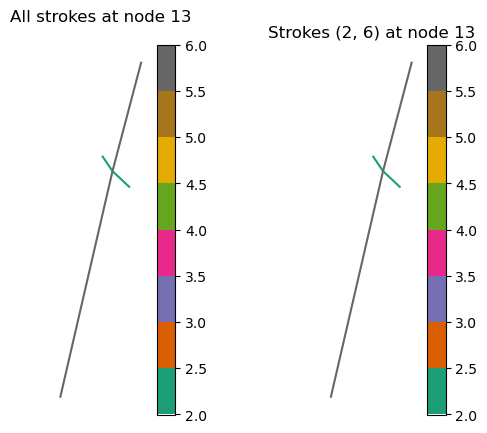

angles_gdf len 4
Interior angles found: [np.float64(47.16443370903167), np.float64(48.92275878691167)]
Interior angles found: [np.float64(59.79419820769666), np.float64(61.55252328557668)]
Final angles found: [np.float64(47.16443370903167), np.float64(59.79419820769666)]
connectivity: 2
Counter values: dict_values([2, 2])
angles: [np.float64(47.16443370903167), np.float64(59.79419820769666)]
(2, 6) already in graph, angles = [np.float64(84.23886881283048), np.float64(80.16976627731358)]
(2, 6) already in graph, angles updated = [np.float64(84.23886881283048), np.float64(80.16976627731358), np.float64(47.16443370903167), np.float64(59.79419820769666)]
**************************************************************
 
 

Node: 14
Adjacent strokes (list): [4, 6, 6, 4]
Adjacent strokes (uniques): {4, 6}
Checking edge: (4, 6)


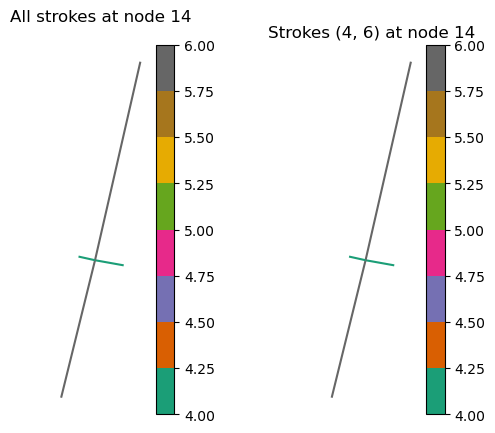

angles_gdf len 4
Interior angles found: [np.float64(87.26341801197296), np.float64(86.2834611843536)]
Interior angles found: [np.float64(89.6026063905527), np.float64(88.62264956293333)]
Final angles found: [np.float64(86.2834611843536), np.float64(88.62264956293333)]
connectivity: 2
Counter values: dict_values([2, 2])
angles: [np.float64(86.2834611843536), np.float64(88.62264956293333)]
(4, 6) added
**************************************************************
 
 

Node: 15
Adjacent strokes (list): [4]
Adjacent strokes (uniques): {4}
**************************************************************
 
 

Node: 16
Adjacent strokes (list): [1, 6, 6]
Adjacent strokes (uniques): {1, 6}
Checking edge: (1, 6)


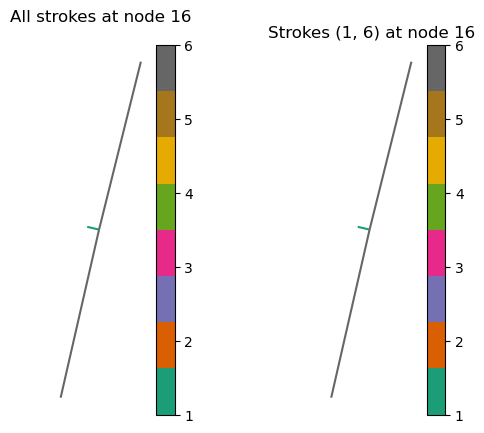

angles_gdf len 3
connectivity: 1
Counter values: dict_values([1, 2])
angles: [np.float64(89.2861856598184)]
(1, 6) added
**************************************************************
 
 

Node: 17
Adjacent strokes (list): [7]
Adjacent strokes (uniques): {7}
**************************************************************
 
 

Node: 18
Adjacent strokes (list): [8, 4, 4]
Adjacent strokes (uniques): {8, 4}
Checking edge: (8, 4)


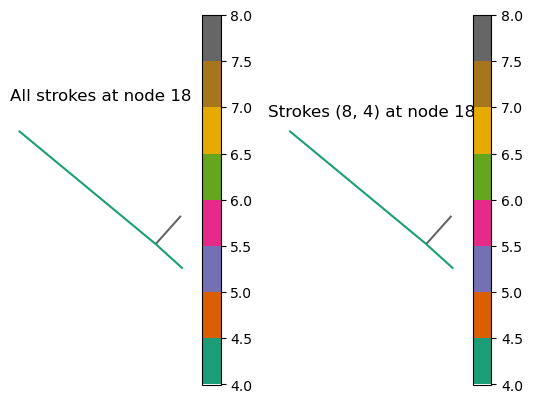

angles_gdf len 3
connectivity: 1
Counter values: dict_values([1, 2])
angles: [np.float64(87.79139488488063)]
(8, 4) added
**************************************************************
 
 

Node: 19
Adjacent strokes (list): [6]
Adjacent strokes (uniques): {6}
**************************************************************
 
 

Node: 20
Adjacent strokes (list): [1]
Adjacent strokes (uniques): {1}
**************************************************************
 
 

Node: 21
Adjacent strokes (list): [9]
Adjacent strokes (uniques): {9}
**************************************************************
 
 

Node: 22
Adjacent strokes (list): [0]
Adjacent strokes (uniques): {0}
**************************************************************
 
 

Node: 23
Adjacent strokes (list): [2]
Adjacent strokes (uniques): {2}
**************************************************************
 
 

Node: 24
Adjacent strokes (list): [6]
Adjacent strokes (uniques): {6}
**************************************************

In [35]:
for n in graph.nodes:

    node_id = graph.nodes[n]["nodeID"] # TODO Remove (only for plotting now)
    print(f"Node: {node_id}")
    
    es = list(graph.edges(n, keys=True))
    stroke_list = [graph.edges[e]["stroke_id"] for e in es]
    stroke_set = set(stroke_list)
    
    print("Adjacent strokes (list):", stroke_list)
    print("Adjacent strokes (uniques):", stroke_set)
    
    # for all size2 combinations from stroke_set
    for c in combinations(stroke_set, 2):
    
        print("Checking edge:", c)
    
        # get angles at that primal node for this 2-stroke combination c
        es = list(graph.edges(n, keys=True))
        stroke_ids = [graph.edges[e]["stroke_id"] for e in es]
        geoms = [graph.edges[e]["geometry"] for e in es]
        segments = [get_segment(geom, n) for geom in geoms] # extracting only edge segments that touch this node
        angles_gdf = gpd.GeoDataFrame(
            {
                "stroke_id": stroke_ids,
                "segment": segments,
                "geometry": [LineString(x) for x in segments]
            }
        )

        # TODO plots can be removed later
        fig, axs = plt.subplots(1,2, sharex=True, sharey=True)
        ax = axs[0]
        angles_gdf.plot(ax=ax, column="stroke_id", legend=True, cmap = "Dark2")
        ax.set_title(f"All strokes at node {node_id}")
        ax.set_axis_off()

        # filter out only those linestring that belong to current 2-stroke edge
        angles_gdf = angles_gdf[angles_gdf.stroke_id.isin(c)].reset_index(drop=True)
        
        # TODO plots can be removed later
        ax = axs[1]
        angles_gdf.plot(ax=ax, column="stroke_id", legend=True, cmap = "Dark2")
        ax.set_title(f"Strokes {c} at node {node_id}")
        ax.set_axis_off()
        
        plt.show()
        

        if len(angles_gdf)==2:

            print("angles_gdf len 2")

            # connectivity equals 1 here
            connectivity = 1

            # angle between 2 strokes is just angle between 
            # the 2 linestrings in the gdf:
            row_a = angles_gdf.loc[0]
            row_b = angles_gdf.loc[1]
            angles = [
                get_interior_angle(
                    row_a.segment[1],
                    row_a.segment[0],
                    row_b.segment[1]
                )
            ]

        elif len(angles_gdf)==3:

            print("angles_gdf len 3")

            # connectivity equals 1 here
            connectivity = 1

            # the iteration has to go through the stroke that appears TWICE
            stroke_count = dict(Counter(angles_gdf.stroke_id))
            stroke_count = {v:k for k,v in stroke_count.items()}
            
            # separate angles_gdf into 2 separate gdf (one for each stroke)
            angles_stroke_a = angles_gdf[angles_gdf["stroke_id"]==stroke_count[1]].copy()
            angles_stroke_b = angles_gdf[angles_gdf["stroke_id"]==stroke_count[2]].copy()

            angles = []
            # there is only ONE row_a stroke segment
            for i, row_a in angles_stroke_a.iterrows():
                angles_stroke = []
                # iterate through BOTH stroke b segments
                for j, row_b in angles_stroke_b.iterrows():
                    assert row_a.segment[0] == row_b.segment[0]
                    # compute angle between stroke a and stroke b segments
                    # and add to list of current angles
                    angles_stroke.append(get_interior_angle(
                        row_a.segment[1],
                        row_a.segment[0],
                        row_b.segment[1])
                    )
            # keep the smaller of the 2 angles to add to list of angles for the stroke pair
            angles.append(min(angles_stroke))

        elif len(angles_gdf)==4:
            print("angles_gdf len 4")

            # connectivity equals 2 here
            connectivity = 2

            # separate angles_gdf into 2 separate gdf (one for each stroke)
            angles_stroke_a = angles_gdf[angles_gdf["stroke_id"]==c[0]].copy()
            angles_stroke_b = angles_gdf[angles_gdf["stroke_id"]==c[1]].copy()

            angles = []
            # iterate through stroke a segments
            for i, row_a in angles_stroke_a.iterrows():
                # iterate through stroke b segments
                angles_partial = []
                for j, row_b in angles_stroke_b.iterrows():
                    assert row_a.segment[0] == row_b.segment[0]
                    # compute angle between stroke a and stroke b segments
                    # and add to list of current angles
                    angle = get_interior_angle(
                        row_a.segment[1],
                        row_a.segment[0],
                        row_b.segment[1])
                    # if angle > 90:
                    #     angle = 180 - angle
                    angles_partial.append(angle)
                print(f"Interior angles found: {angles_partial}")
                angles.append(min(angles_partial)) # @csebastiao we're keeping the minimal here?
            print(f"Final angles found: {angles}")

        else:
            ValueError(f"Length of angles_gdf expected to be in [2,3,4], but is {len(angles_gdf)}")

        #### now that we have connectivity and angles, 
        print(f"connectivity: {connectivity}")
        print("Counter values:", Counter(angles_gdf.stroke_id).values())
        print("angles:", angles)

        # connectivity is added at stroke node level:
        for s in c:
            stroke_graph.nodes[s]["connectivity"] += connectivity

        # and edge (or update edge info) at stroke edge level:
        if c not in stroke_graph.edges:
            edge_geom = LineString(
                [
                    stroke_graph.nodes[c[0]]["geometry"],
                    stroke_graph.nodes[c[1]]["geometry"]
                ]
            )
            stroke_graph.add_edge(
                c[0],
                c[1],
                geometry=edge_geom,
                angles=angles
            )
            print(f"{c} added")

        else:
            print(f"{c} already in graph, angles =", stroke_graph.edges[c]["angles"])
            stroke_graph.edges[c]["angles"] += angles
            print(f"{c} already in graph, angles updated =", stroke_graph.edges[c]["angles"])
    print("**************************************************************\n \n \n")
# we want to add edges for all stroke IDs that co-occur on edges that share the same node in the primal graph
# [0, 1, 1] means: stroke0 has an endpoint here; stroke1 has a throughpoint here; we add the edge [0,1] in the strokes_graph, with the attribute 
# stroke = {0: "end", 1: "through"}
 

**We want as final output:**

A networkx `Graph()` object (undirected, simple)

* nodes represent strokes,
* edges represent stroke connections (intersecting, ie crossing or touching)

* edges: attributes: 
    * angles 
    * number of connections
* nodes: attributes:
    *should be inheriting from all primal edge attrs, at least:*
    * geometry
    * length

***

next step: functions to add attrs on the nodes (strokes):
* degree, closeness, betweenness (by def nx) 
* connectivity == number of angles (total nr of connections, min=degree)
* access (abs diff connectivity-degree)
* spacing = length / connectivity
* orthogonality = average angle (sum of angles / connectivity)

In [36]:
# add graph metrics

# betweenness centrality dict for all nodes
bc = nx.betweenness_centrality(stroke_graph)

# closeness centrality dict for all nodes
cc = nx.closeness_centrality(stroke_graph)

for n in stroke_graph.nodes:
    
    stroke_graph.nodes[n]["degree"] = nx.degree(stroke_graph, n)
    stroke_graph.nodes[n]["betweenness_centrality"] = bc[n]
    stroke_graph.nodes[n]["closeness_centrality"] = cc[n]

    # just for sanity check # TODO can be removed later
    stroke_graph.nodes[n]["connectivity_computed"] = sum(
        [len(stroke_graph.edges[edge]["angles"]) for edge in stroke_graph.edges(n)]
    )        
    assert stroke_graph.nodes[n]["connectivity"] == stroke_graph.nodes[n]["connectivity_computed"]

    # access = abs(connectivity - degree)
    stroke_graph.nodes[n]["access"] = abs(stroke_graph.nodes[n]["connectivity"] - stroke_graph.nodes[n]["degree"])

    # spacing = length / connectivity
    stroke_graph.nodes[n]["length"] = stroke_graph.nodes[n]["geometry_stroke"].length # compute length first
    stroke_graph.nodes[n]["spacing"] = stroke_graph.nodes[n]["length"] / stroke_graph.nodes[n]["connectivity"]

    # orthogonality = sum(angles) / connectivity
    # compute sum of angles of edges of that node first
    node_angles = [stroke_graph.edges[edge]["angles"] for edge in stroke_graph.edges(n)]
    node_angles = [item for sublist in node_angles for item in sublist] # un-nest list
    stroke_graph.nodes[n]["orthogonality"] = sum(node_angles)/stroke_graph.nodes[n]["connectivity"]


Save as pickle

In [37]:
# after iteration finished, save results:
with open('stroke_graph_anvy.pickle', 'wb') as handle:
    pickle.dump(stroke_graph, handle, protocol=pickle.HIGHEST_PROTOCOL)

# # to read back in:
# with open('stroke_graph.pickle', 'rb') as handle:
#     G = pickle.load(handle)

**Plot final results**

In [38]:
# get gdfs of points and lines
points_strokes, lines_strokes = momepy.nx_to_gdf(stroke_graph, points=True, lines=True)
# and also one with the prinal stroke geoms
points_strokes_primal = points_strokes.copy()
points_strokes_primal=points_strokes_primal.set_geometry("geometry_stroke")
points_strokes_primal=points_strokes_primal.set_crs(points_strokes.crs)

In [39]:
stroke_metrics = [
    'connectivity',
    'degree',
    'betweenness_centrality',
    'closeness_centrality',
    'access',
    'length', 
    'spacing',
    'orthogonality'
]

**Final result for now**

In [40]:
m = points_strokes_primal.explore(
    tiles="cartodb.positron",
    column = "nodeID",
    name = "strokes (original geoms)",
    cmap = "tab20c", 
    style_kwds={"weight":8},
    opacity=0.9
)
points_strokes[["geometry", "connectivity"]].explore(
    m=m,
    marker_kwds={"radius":10}, 
    name ="stroke nodes",
    column = "connectivity", 
    cmap = "Purples",
    #opacity=0.2
    )

for metric in stroke_metrics:
    points_strokes_primal.explore(
        m=m,
        column=metric,
        cmap="Reds",
        name=f"{metric}")

lines_strokes[["geometry", "angles"]].explore(m=m, 
    name = "Stroke graph edges",
    color = "black",
    style_kwds={"weight":1},
    dash_array=2

)
folium.LayerControl().add_to(m)
m